In [1]:
#from project_utilities import *
from emg_functions import *

[0.1, 0.08, 0.12, 0.1, 0.12, 0.11, 0.09, 0.1, 0.11, 0.09, 0.1, 0.13, 0.1, 0.08, 0.08, 0.15, 0.08, 0.14, 0.16, 0.16, 0.16, 0.11, 0.14, 0.16, 0.09, 0.14, 0.1, 0.09, 0.16, 0.12, 0.14, 0.09, 0.11]
[0.08, 0.08, 0.13, 0.12, 0.11, 0.15, 0.09, 0.09, 0.12, 0.15, 0.08, 0.12, 0.11, 0.08, 0.08]


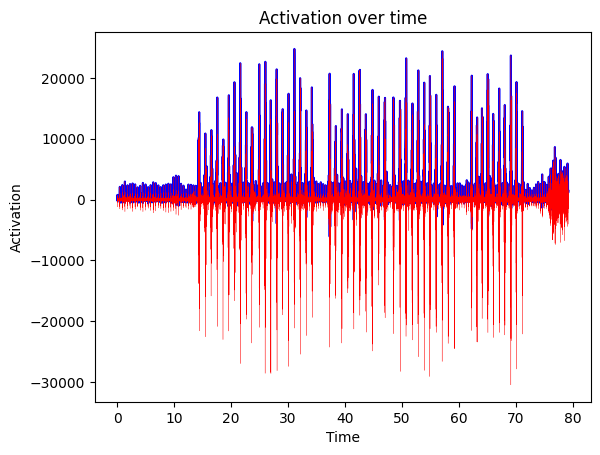

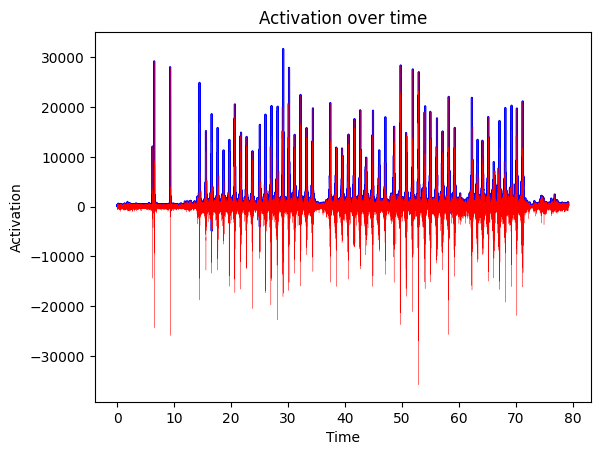

In [2]:
emgFilePath = './data/EMG_data/saffie_hook.txt'#'opensignals_0007804b3c23_2024-09-09_15-04-53.txt'
#--- manuell open (in pipeline)
#Open and reads the file with the EMG data to a long text string and saves it to rawData. Closes the file at the end.
with open(emgFilePath, 'r') as file:     
    rawData = file.read()      
    file.close
    pass        
#---
signalThreshold = 35000
sampleRate = get_sample_rate(rawData)


dataWithHeader = get_emg_data(rawData,sampleRate)
timeAdjustedEmg = find_first_punch(dataWithHeader,signalThreshold) #adjusted data is [time:EMG data Arm, EMG data chest]

emgDataArm = []
emgDataChest = []
timeValues = []
for row in timeAdjustedEmg:
    timeValues.append(row[0])
    emgDataArm.append(row[1])
    emgDataChest.append(row[2])

#filterdSignal = find_first_punch(dataTable, threshold)
lowcut = 20
highcut = 450
adjustedEmgArm = apply_filter(emgDataArm, lowcut, highcut, sampleRate) # adjustedEmg = filteredSignal
adjustedEmgChest = apply_filter(emgDataChest, lowcut, highcut, sampleRate)

window = 10
diffThreashold = 7
envelopeValuesArm,timeValuesEnvelopeArm = envelope_emg(adjustedEmgArm,window,sampleRate)
envelopeValuesChest,timeValuesEnvelopeChest = envelope_emg(adjustedEmgChest,window,sampleRate)
zoomThreshold = 3000


muscleActivationTimeArm = get_muscle_time(envelopeValuesArm,zoomThreshold,window,sampleRate,diffThreashold)
muscleActivationTimeChest = get_muscle_time(envelopeValuesChest,zoomThreshold,window,sampleRate,diffThreashold)
print(muscleActivationTimeArm)
print(muscleActivationTimeChest)
plt.plot(timeValuesEnvelopeArm, envelopeValuesArm, "b")
plt.plot(timeValues,adjustedEmgArm, "r", lw = 0.2) 
plt.xlabel('Time')
plt.ylabel('Activation')
plt.title('Activation over time')
plt.show()

plt.plot(timeValuesEnvelopeChest, envelopeValuesChest, "b")
plt.plot(timeValues,adjustedEmgChest, "r", lw = 0.2) 
plt.xlabel('Time')
plt.ylabel('Activation')
plt.title('Activation over time')
plt.show()